In [ ]:
# --- Cell 1: Installation & Setup ---
print("Installing dependencies...")
!pip install -q transformers datasets accelerate pandas scikit-learn

import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import pandas as pd
import sys

# --- Hardware Check ---
print("\n--- Hardware Check ---")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"   VRAM Available: {vram:.2f} GB")
else:
    device = torch.device("cpu")
    print("⚠️ WARNING: No GPU detected. Go to Runtime > Change runtime type > T4 GPU")

# --- Load Universal Backbone (XLM-RoBERTa Large) ---
MODEL_NAME = "xlm-roberta-large"
print(f"\n--- Loading Model: {MODEL_NAME} ---")

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME).to(device)
    print("✅ Model loaded successfully onto GPU.")
except Exception as e:
    print(f"❌ Error loading model: {e}")

# --- Sanity Check: Test Inference ---
print(f"\n--- Testing Forward Pass (Embedding Generation) ---")
sample_text = "I feel overwhelmed and alone."
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=128).to(device)

with torch.no_grad():
    outputs = model(**inputs)

# The 'last_hidden_state' is the rich representation of the text
# Shape: (Batch_Size, Sequence_Length, Hidden_Dimension)
print(f"✅ Input: '{sample_text}'")
print(f"   Output Vector Shape: {outputs.last_hidden_state.shape}")
# Expected for XLM-R Large: (1, seq_len, 1024)

# --- Load and Inspect Dataset ---
DATASET_NAME = "phoenix1803/Mental-Health-LongParas"
print(f"\n--- Loading Dataset: {DATASET_NAME} ---")

try:
    dataset = load_dataset(DATASET_NAME)
    print("✅ Dataset loaded.")

    # Convert first 5 rows to Pandas for easy viewing
    df = pd.DataFrame(dataset['train'].select(range(5)))

    print("\n--- 📋 AVAILABLE COLUMNS ---")
    print(df.columns.tolist())

    print("\n--- 🔍 SAMPLE ROW (First Entry) ---")
    # Transpose for easier reading
    print(df.iloc[0].T)

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("Note: If the dataset is private, you may need to run: from huggingface_hub import notebook_login; notebook_login()")

Installing dependencies...

--- Hardware Check ---
✅ GPU Detected: NVIDIA A100-SXM4-80GB
   VRAM Available: 85.17 GB

--- Loading Model: xlm-roberta-large ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

✅ Model loaded successfully onto GPU.

--- Testing Forward Pass (Embedding Generation) ---
✅ Input: 'I feel overwhelmed and alone.'
   Output Vector Shape: torch.Size([1, 11, 1024])

--- Loading Dataset: phoenix1803/Mental-Health-LongParas ---


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

mental_health_long_paras.csv:   0%|          | 0.00/160M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

✅ Dataset loaded.

--- 📋 AVAILABLE COLUMNS ---
['text', 'label', 'label_id', 'word_count', 'sample_type', 'sentiment_intensity', 'personal_context', 'family_history', 'trauma_indicators', 'social_isolation_score', 'support_system_strength']

--- 🔍 SAMPLE ROW (First Entry) ---
text                       The body remembers what I try to forget. My ja...
label                                                          trauma_stress
label_id                                                                   1
word_count                                                               220
sample_type                                                             long
sentiment_intensity                                                      0.0
personal_context                                                           1
family_history                                                             0
trauma_indicators                                                          2
social_isolation_score        

In [ ]:
# --- Cell 2: Load Full Data, Analyze & Split ---
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 1. Load the FULL dataset (Step 1 only loaded 5 rows)
print("--- ⏳ Loading Full Dataset (120k rows)... ---")
# This might take 10-20 seconds
df_full = dataset['train'].to_pandas()
print(f"✅ Full Data Loaded. Shape: {df_full.shape}")

# 2. Re-Analyze the 6 Target Columns (on the full data)
target_cols = [
    'sentiment_intensity',
    'family_history',
    'trauma_indicators',
    'social_isolation_score',
    'support_system_strength'
]

print("\n--- 📊 TRUE Target Variable Analysis ---")
for col in target_cols:
    unique_vals = df_full[col].unique()
    n_unique = len(unique_vals)
    print(f"\nColumn: {col}")
    # Show min/max to understand the range
    print(f"  Range: {df_full[col].min()} to {df_full[col].max()}")
    print(f"  Unique Values Count: {n_unique}")

    # Check if it looks continuous or categorical
    if n_unique < 15:
        print(f"  Values: {sorted(unique_vals)}")

# 3. Perform Stratified 70/30 Split
print("\n--- ✂️ Performing Stratified 70/30 Split ---")

# Filter out rare categories that have fewer than 2 examples (cannot be stratified)
# In 120k rows, this is rare, but good safety practice.
v_counts = df_full['label'].value_counts()
valid_labels = v_counts[v_counts >= 2].index
df_filtered = df_full[df_full['label'].isin(valid_labels)].copy()

train_df, temp_df = train_test_split(df_filtered, test_size=0.30, stratify=df_filtered['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'])



print(f"Training Set: {len(train_df)} rows")
print(f"Testing Set:  {len(test_df)} rows")

# 4. Save to disk (Optional but good for Colab crashes)
# train_df.to_csv("train_split.csv", index=False)
# test_df.to_csv("test_split.csv", index=False)
print("✅ Split Complete.")

--- ⏳ Loading Full Dataset (120k rows)... ---
✅ Full Data Loaded. Shape: (120000, 11)

--- 📊 TRUE Target Variable Analysis ---

Column: sentiment_intensity
  Range: -0.9333333333333332 to 0.8888888888888888
  Unique Values Count: 93

Column: family_history
  Range: 0 to 1
  Unique Values Count: 2
  Values: [np.int64(0), np.int64(1)]

Column: trauma_indicators
  Range: 0 to 7
  Unique Values Count: 8
  Values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

Column: social_isolation_score
  Range: 0 to 4
  Unique Values Count: 5
  Values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Column: support_system_strength
  Range: 0.0 to 0.0384615384615384
  Unique Values Count: 234

--- ✂️ Performing Stratified 80/20 Split ---
Training Set: 84000 rows
Testing Set:  18000 rows
✅ Split Complete.


In [ ]:
# --- Cell 3: Define Dataset and Multi-Task Model ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. Define the Custom Dataset
class MentalHealthDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row["text"])

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),   # (seq_len,)
            "attention_mask": encoding["attention_mask"].squeeze(0),
            # Targets (5 dimensions)
            "sentiment": torch.tensor(row["sentiment_intensity"], dtype=torch.float),
            "family": torch.tensor(row["family_history"], dtype=torch.float),  # 0.0 or 1.0
            "trauma": torch.tensor(row["trauma_indicators"], dtype=torch.float),
            "isolation": torch.tensor(row["social_isolation_score"], dtype=torch.float),
            "support": torch.tensor(row["support_system_strength"]*100.00, dtype=torch.float),
        }

# 2. Define the Multi-Task Model
class MultiTaskModel(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.backbone = pretrained_model
        self.hidden_size = self.backbone.config.hidden_size  # 1024 for xlm-roberta-large

        # Optionally freeze backbone for first training runs
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Heads
        self.head_sentiment = nn.Linear(self.hidden_size, 1)   # regression
        self.head_family = nn.Linear(self.hidden_size, 1)      # binary logit
        self.head_trauma = nn.Linear(self.hidden_size, 1)      # regression
        self.head_isolation = nn.Linear(self.hidden_size, 1)   # regression
        self.head_support = nn.Linear(self.hidden_size, 1)     # regression

        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)

        # CLS token embedding (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embedding = self.dropout(cls_embedding)

        return {
            "sentiment": self.head_sentiment(cls_embedding),    # (batch, 1)
            "family": self.head_family(cls_embedding),          # (batch, 1)
            "trauma": self.head_trauma(cls_embedding),          # (batch, 1)
            "isolation": self.head_isolation(cls_embedding),    # (batch, 1)
            "support": self.head_support(cls_embedding),        # (batch, 1)
        }

print("✅ Dataset and MultiTaskModel classes defined.")

# --- Sanity Check: Create one batch and run it ---
debug_ds = MentalHealthDataset(train_df.iloc[:10], tokenizer)
debug_loader = DataLoader(debug_ds, batch_size=2)

multitask_model = MultiTaskModel(model).to(device)

batch = next(iter(debug_loader))
input_ids = batch["input_ids"].to(device)
mask = batch["attention_mask"].to(device)

with torch.no_grad():
    preds = multitask_model(input_ids, mask)

print("\n--- 🧪 Model Architecture Test ---")
print("Input shape:", input_ids.shape)
print("Outputs (5 heads):")
for key, val in preds.items():
    print(f" {key}: shape {val.shape} | sample: {val[0].item():.4f}")

✅ Dataset and MultiTaskModel classes defined.

--- 🧪 Model Architecture Test ---
Input shape: torch.Size([2, 256])
Outputs (5 heads):
 sentiment: shape torch.Size([2, 1]) | sample: -0.6369
 family: shape torch.Size([2, 1]) | sample: -0.5152
 trauma: shape torch.Size([2, 1]) | sample: 0.6708
 isolation: shape torch.Size([2, 1]) | sample: -0.4375
 support: shape torch.Size([2, 1]) | sample: 0.3420


--- 🚀 Final Training Pipeline ---
Epochs: 5 | Batch Size: 32 | LR (heads): 0.001
family_history pos_weight: 8.22
Trainable tensors (heads only): 10

--- Epoch 1/5 ---


/tmp/ipython-input-329015072.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


Training:   0%|          | 0/2625 [00:00<?, ?it/s]

/tmp/ipython-input-329015072.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/563 [00:00<?, ?it/s]

✅ Results: Train Loss=2.3174 | Val Loss=2.0205
   Train sentiment loss: 0.1343 | Val sentiment loss: 0.1320
   Train trauma    loss: 0.7039 | Val trauma    loss: 0.5746
   Train isolation loss: 0.3273 | Val isolation loss: 0.3077
   Train support   loss: 0.3790 | Val support   loss: 0.3411
   Train family    loss: 0.7730 | Val family    loss: 0.6651
💾 New Best Model Saved!

--- Epoch 2/5 ---
📉 Learning Rate decayed to 5.00e-04


Training:   0%|          | 0/2625 [00:00<?, ?it/s]

Validating:   0%|          | 0/563 [00:00<?, ?it/s]

✅ Results: Train Loss=2.2897 | Val Loss=1.9696
   Train sentiment loss: 0.1317 | Val sentiment loss: 0.1139
   Train trauma    loss: 0.6955 | Val trauma    loss: 0.5645
   Train isolation loss: 0.3250 | Val isolation loss: 0.3068
   Train support   loss: 0.3726 | Val support   loss: 0.3427
   Train family    loss: 0.7649 | Val family    loss: 0.6417
💾 New Best Model Saved!

--- Epoch 3/5 ---
📉 Learning Rate decayed to 2.50e-04


Training:   0%|          | 0/2625 [00:00<?, ?it/s]

Validating:   0%|          | 0/563 [00:00<?, ?it/s]

✅ Results: Train Loss=2.2681 | Val Loss=1.9650
   Train sentiment loss: 0.1293 | Val sentiment loss: 0.1114
   Train trauma    loss: 0.6902 | Val trauma    loss: 0.5683
   Train isolation loss: 0.3212 | Val isolation loss: 0.3065
   Train support   loss: 0.3707 | Val support   loss: 0.3411
   Train family    loss: 0.7567 | Val family    loss: 0.6378
💾 New Best Model Saved!

--- Epoch 4/5 ---
📉 Learning Rate decayed to 1.25e-04


Training:   0%|          | 0/2625 [00:00<?, ?it/s]

Validating:   0%|          | 0/563 [00:00<?, ?it/s]

✅ Results: Train Loss=2.2657 | Val Loss=1.9637
   Train sentiment loss: 0.1288 | Val sentiment loss: 0.1128
   Train trauma    loss: 0.6848 | Val trauma    loss: 0.5662
   Train isolation loss: 0.3208 | Val isolation loss: 0.3054
   Train support   loss: 0.3693 | Val support   loss: 0.3420
   Train family    loss: 0.7621 | Val family    loss: 0.6372
💾 New Best Model Saved!

--- Epoch 5/5 ---
📉 Learning Rate decayed to 6.25e-05


Training:   0%|          | 0/2625 [00:00<?, ?it/s]

Validating:   0%|          | 0/563 [00:00<?, ?it/s]

✅ Results: Train Loss=2.2618 | Val Loss=1.9601
   Train sentiment loss: 0.1279 | Val sentiment loss: 0.1099
   Train trauma    loss: 0.6875 | Val trauma    loss: 0.5659
   Train isolation loss: 0.3196 | Val isolation loss: 0.3067
   Train support   loss: 0.3678 | Val support   loss: 0.3427
   Train family    loss: 0.7590 | Val family    loss: 0.6349
💾 New Best Model Saved!

🏆 Final Best Validation Loss: 1.9601


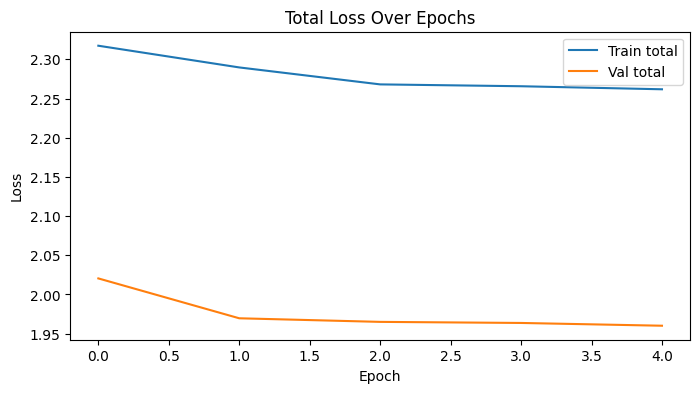

In [ ]:
# --- Cell 4: Training (2 epochs, LR decay) with per-head losses & pos_weight ---
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.notebook import tqdm
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt

# --- Configuration ---
BATCH_SIZE = 32        # keep if VRAM allows; drop to 16 if OOM
LR = 1e-3              # higher LR for HEADS ONLY (backbone frozen)
EPOCHS = 5

print(f"--- 🚀 Final Training Pipeline ---")
print(f"Epochs: {EPOCHS} | Batch Size: {BATCH_SIZE} | LR (heads): {LR}")

# 1. DataLoaders
# If you only have train_df/test_df, you can treat test_df as val_df for now.
train_ds = MentalHealthDataset(train_df, tokenizer)
val_ds   = MentalHealthDataset(val_df, tokenizer)   # use val set, not test
test_ds  = MentalHealthDataset(test_df, tokenizer)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# 2. Loss functions
mse_loss_fn = nn.MSELoss()

# compute class imbalance for family_history
pos_count = (train_df["family_history"] == 1).sum()
neg_count = (train_df["family_history"] == 0).sum()
if pos_count > 0:
    pos_weight_val = neg_count / pos_count
else:
    pos_weight_val = 1.0

print(f"family_history pos_weight: {pos_weight_val:.2f}")
bce_loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight_val], device=device)
)

# 3. Optimizer – HEADS ONLY
head_params = [
    p for name, p in multitask_model.named_parameters()
    if p.requires_grad and "head_" in name
]
print(f"Trainable tensors (heads only): {len(head_params)}")
optimizer = AdamW(head_params, lr=LR)

use_amp = (device.type == "cuda")
scaler = GradScaler(enabled=use_amp)

# 4. LR decay (same as your original)
def adjust_learning_rate(optimizer, epoch):
    """Halves the learning rate after Epoch 1"""
    if epoch > 0:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5
        print(f"📉 Learning Rate decayed to {optimizer.param_groups[0]['lr']:.2e}")

# 5. Per-head weights (you can tweak if one head dominates)
HEAD_WEIGHTS = {
    "sentiment": 1.0,
    "trauma":    1.0,
    "isolation": 1.0,
    "support":   1.0,
    "family":    1.0,
}

# 6. Train Function (returns total + per-head losses)
def train_simple(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    n_batches = 0

    head_loss_sum = {
        "sentiment": 0.0,
        "trauma":    0.0,
        "isolation": 0.0,
        "support":   0.0,
        "family":    0.0,
    }

    loop = tqdm(loader, leave=True, desc="Training")

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        mask      = batch["attention_mask"].to(device)
        targets = {
            k: v.to(device).unsqueeze(1)
            for k, v in batch.items()
            if k not in ["input_ids", "attention_mask"]
        }

        optimizer.zero_grad()

        if use_amp:
            with autocast():
                outputs = multitask_model(input_ids, mask)

                loss_sent  = mse_loss_fn(outputs["sentiment"], targets["sentiment"])
                loss_traum = mse_loss_fn(outputs["trauma"],    targets["trauma"])
                loss_iso   = mse_loss_fn(outputs["isolation"], targets["isolation"])
                loss_sup   = mse_loss_fn(outputs["support"],   targets["support"])
                loss_fam   = bce_loss_fn(outputs["family"],    targets["family"])

                loss = (
                    HEAD_WEIGHTS["sentiment"] * loss_sent +
                    HEAD_WEIGHTS["trauma"]    * loss_traum +
                    HEAD_WEIGHTS["isolation"] * loss_iso +
                    HEAD_WEIGHTS["support"]   * loss_sup +
                    HEAD_WEIGHTS["family"]    * loss_fam
                )

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = multitask_model(input_ids, mask)

            loss_sent  = mse_loss_fn(outputs["sentiment"], targets["sentiment"])
            loss_traum = mse_loss_fn(outputs["trauma"],    targets["trauma"])
            loss_iso   = mse_loss_fn(outputs["isolation"], targets["isolation"])
            loss_sup   = mse_loss_fn(outputs["support"],   targets["support"])
            loss_fam   = bce_loss_fn(outputs["family"],    targets["family"])

            loss = (
                HEAD_WEIGHTS["sentiment"] * loss_sent +
                HEAD_WEIGHTS["trauma"]    * loss_traum +
                HEAD_WEIGHTS["isolation"] * loss_iso +
                HEAD_WEIGHTS["support"]   * loss_sup +
                HEAD_WEIGHTS["family"]    * loss_fam
            )

            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        n_batches  += 1

        head_loss_sum["sentiment"] += loss_sent.item()
        head_loss_sum["trauma"]    += loss_traum.item()
        head_loss_sum["isolation"] += loss_iso.item()
        head_loss_sum["support"]   += loss_sup.item()
        head_loss_sum["family"]    += loss_fam.item()

        loop.set_description(f"Train (loss={loss.item():.4f})")

    avg_total = total_loss / max(n_batches, 1)
    avg_heads = {k: v / max(n_batches, 1) for k, v in head_loss_sum.items()}
    return avg_total, avg_heads

# 7. Evaluate Function (same structure, no grad)
def evaluate_simple(model, loader):
    model.eval()
    total_loss = 0.0
    n_batches = 0

    head_loss_sum = {
        "sentiment": 0.0,
        "trauma":    0.0,
        "isolation": 0.0,
        "support":   0.0,
        "family":    0.0,
    }

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            mask      = batch["attention_mask"].to(device)
            targets = {
                k: v.to(device).unsqueeze(1)
                for k, v in batch.items()
                if k not in ["input_ids", "attention_mask"]
            }

            outputs = multitask_model(input_ids, mask)

            loss_sent  = mse_loss_fn(outputs["sentiment"], targets["sentiment"])
            loss_traum = mse_loss_fn(outputs["trauma"],    targets["trauma"])
            loss_iso   = mse_loss_fn(outputs["isolation"], targets["isolation"])
            loss_sup   = mse_loss_fn(outputs["support"],   targets["support"])
            loss_fam   = bce_loss_fn(outputs["family"],    targets["family"])

            loss = (
                HEAD_WEIGHTS["sentiment"] * loss_sent +
                HEAD_WEIGHTS["trauma"]    * loss_traum +
                HEAD_WEIGHTS["isolation"] * loss_iso +
                HEAD_WEIGHTS["support"]   * loss_sup +
                HEAD_WEIGHTS["family"]    * loss_fam
            )

            total_loss += loss.item()
            n_batches  += 1

            head_loss_sum["sentiment"] += loss_sent.item()
            head_loss_sum["trauma"]    += loss_traum.item()
            head_loss_sum["isolation"] += loss_iso.item()
            head_loss_sum["support"]   += loss_sup.item()
            head_loss_sum["family"]    += loss_fam.item()

    avg_total = total_loss / max(n_batches, 1)
    avg_heads = {k: v / max(n_batches, 1) for k, v in head_loss_sum.items()}
    return avg_total, avg_heads

# 8. EXECUTION + simple loss history for plotting
best_loss = float("inf")
best_weights = None

history = {
    "train_total": [],
    "val_total":   [],
    "train_heads": [],
    "val_heads":   [],
}

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    adjust_learning_rate(optimizer, epoch)

    train_loss, train_heads = train_simple(multitask_model, train_loader, optimizer)
    val_loss,   val_heads   = evaluate_simple(multitask_model, val_loader)

    history["train_total"].append(train_loss)
    history["val_total"].append(val_loss)
    history["train_heads"].append(train_heads)
    history["val_heads"].append(val_heads)

    print(f"✅ Results: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")
    for k in train_heads:
        print(f"   Train {k:9s} loss: {train_heads[k]:.4f} | Val {k:9s} loss: {val_heads[k]:.4f}")

    if val_loss < best_loss:
        best_loss   = val_loss
        best_weights = copy.deepcopy(multitask_model.state_dict())
        print("💾 New Best Model Saved!")

# Restore best
if best_weights is not None:
    multitask_model.load_state_dict(best_weights)
print(f"\n🏆 Final Best Validation Loss: {best_loss:.4f}")

# 9. Simple loss curve visualization
plt.figure(figsize=(8,4))
plt.plot(history["train_total"], label="Train total")
plt.plot(history["val_total"],   label="Val total")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Loss Over Epochs")
plt.legend()
plt.show()


In [ ]:
# --- Sanity Check for training heads. ---
for name, p in multitask_model.named_parameters():
    if p.requires_grad:
        print("TRAINABLE:", name)

# --- Quick Fix: Generate Predictions for Analysis ---
print("Generating predictions for analysis...")

# Reuse the evaluate function logic to extract data
def get_predictions(model, loader):
    model.eval()
    all_preds = {k: [] for k in ['sentiment', 'trauma', 'isolation', 'support', 'family']}
    all_targets = {k: [] for k in ['sentiment', 'trauma', 'isolation', 'support', 'family']}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating Preds"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = {k: v.to(device).unsqueeze(1) for k, v in batch.items()
                       if k not in ['input_ids', 'attention_mask']}

            outputs = model(input_ids, mask)

            for k in all_preds.keys():
                all_preds[k].extend(outputs[k].cpu().numpy().flatten())
                all_targets[k].extend(targets[k].cpu().numpy().flatten())

    return all_preds, all_targets

# Run it
preds, true_vals = get_predictions(multitask_model, test_loader)
print("✅ Predictions ready. Now run Cell 5!")

TRAINABLE: head_sentiment.weight
TRAINABLE: head_sentiment.bias
TRAINABLE: head_family.weight
TRAINABLE: head_family.bias
TRAINABLE: head_trauma.weight
TRAINABLE: head_trauma.bias
TRAINABLE: head_isolation.weight
TRAINABLE: head_isolation.bias
TRAINABLE: head_support.weight
TRAINABLE: head_support.bias
Generating predictions for analysis...


Generating Preds:   0%|          | 0/563 [00:00<?, ?it/s]

✅ Predictions ready. Now run Cell 5!


--- 📊 Model Performance Report (Validation) ---

🔹 [Task: SENTIMENT] (Regression)
 MAE: 0.2655
 R²:  0.3376

🔹 [Task: TRAUMA] (Regression)
 MAE: 0.5389
 R²:  0.4311

🔹 [Task: ISOLATION] (Regression)
 MAE: 0.4812
 R²:  0.1644

🔹 [Task: SUPPORT] (Regression)
 MAE: 0.4815
 R²:  0.1632

🔹 [Task: FAMILY] (Classification)
 Accuracy: 91.22%
 F1-Score: 0.6884
 ROC-AUC: 0.9324


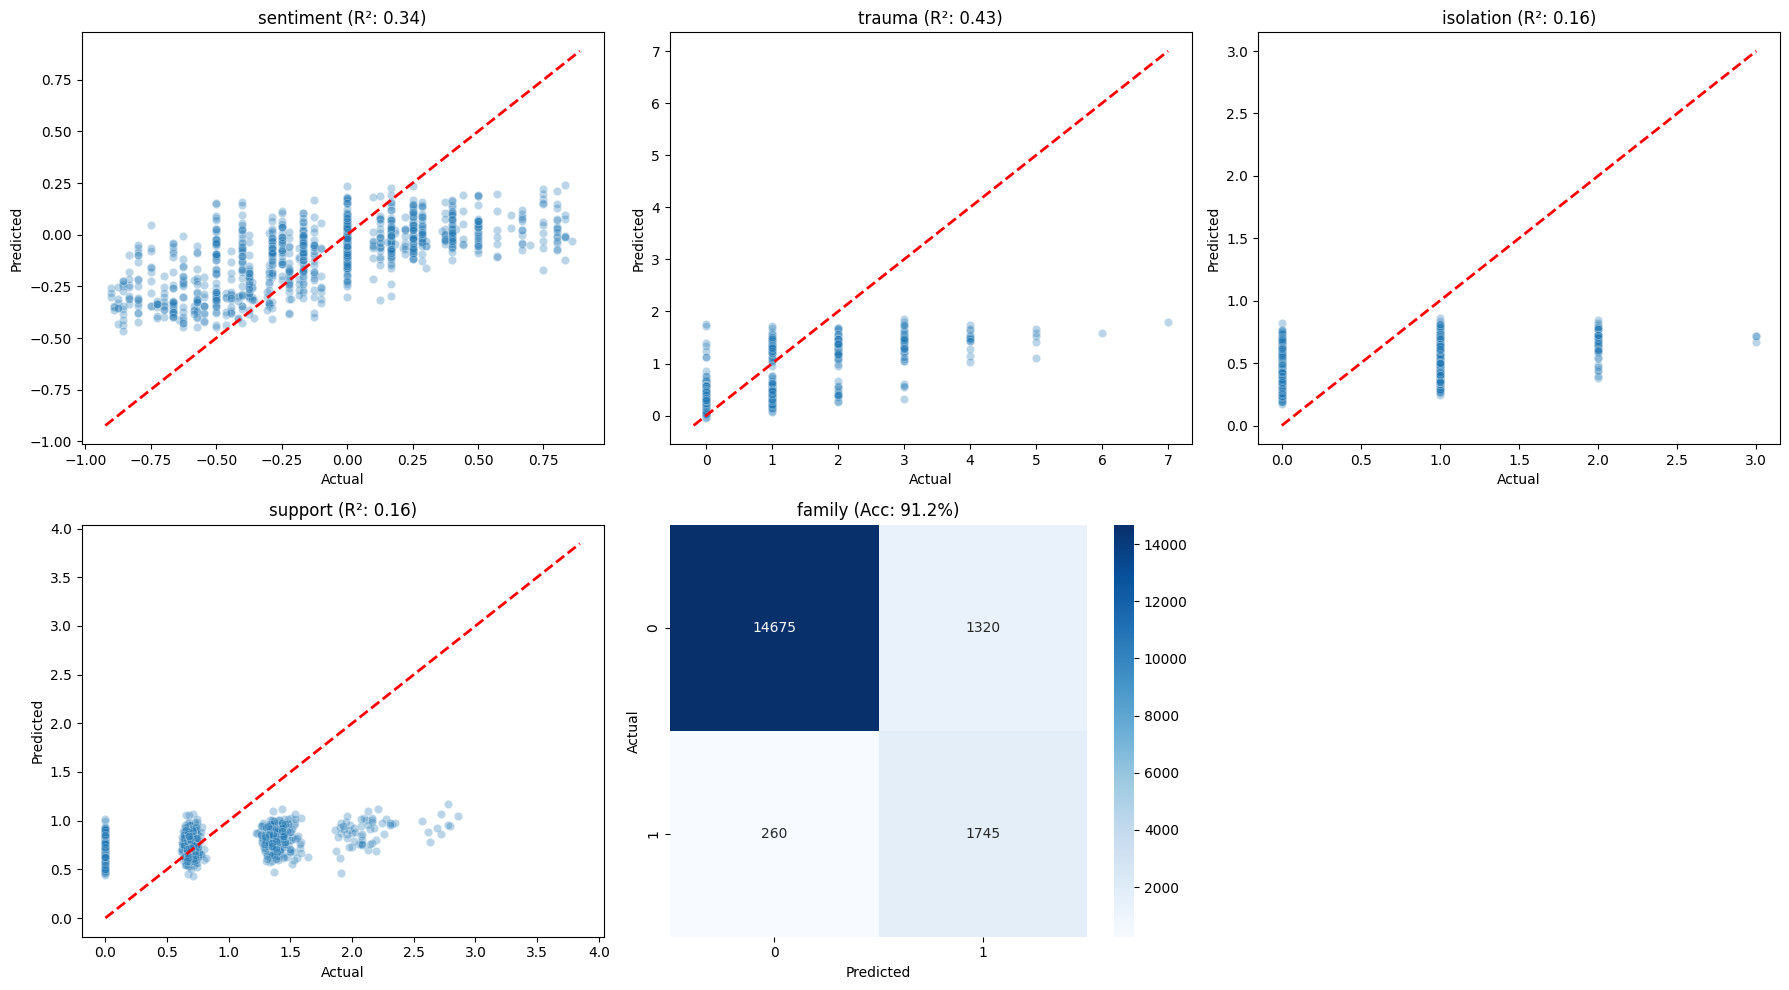

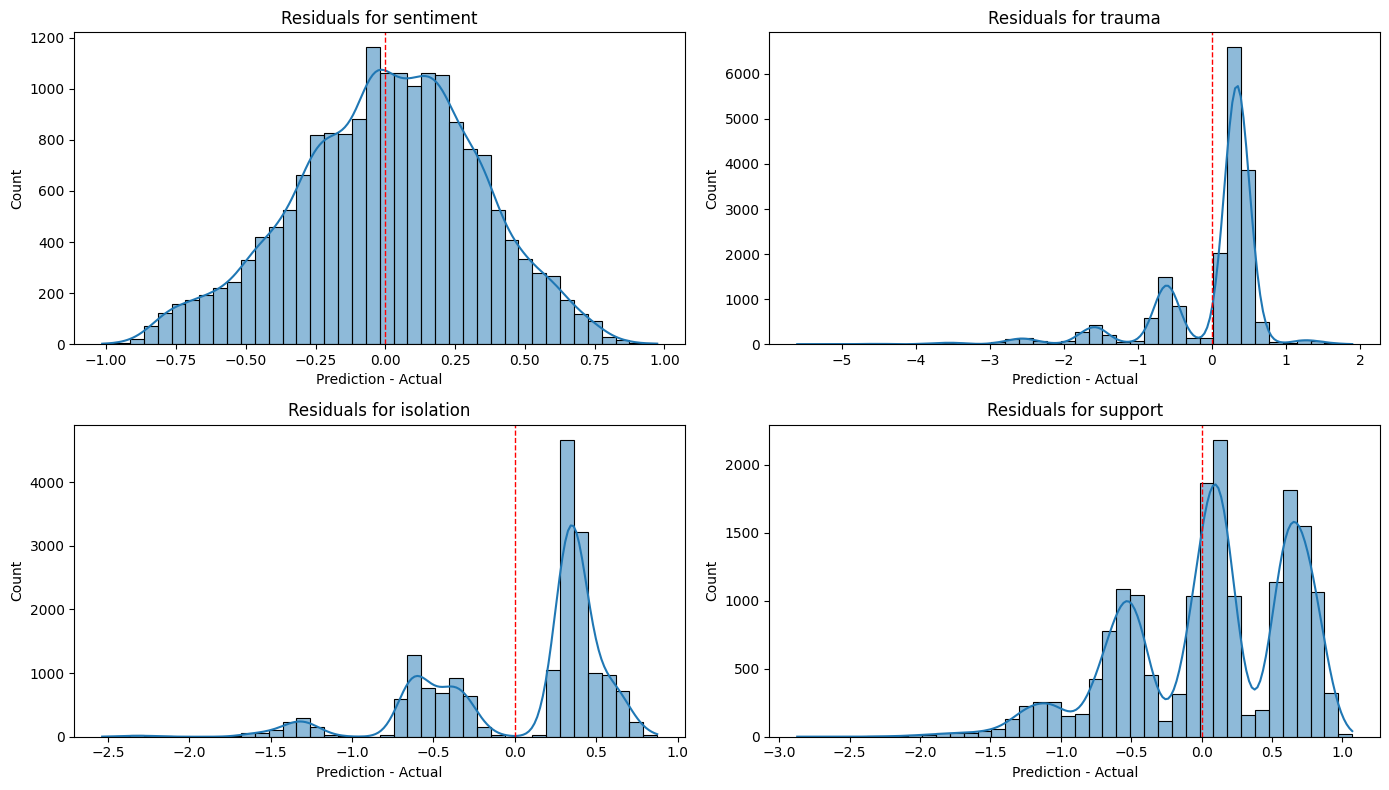


--- ✅ Recommended Action (heuristic) ---
Task: sentiment  | Metric=r2 | Score=0.338 | Recommendation: KEEP
Task: trauma     | Metric=r2 | Score=0.431 | Recommendation: KEEP
Task: isolation  | Metric=r2 | Score=0.164 | Recommendation: DISCARD
Task: support    | Metric=r2 | Score=0.163 | Recommendation: DISCARD
Task: family     | Metric=f1 | Score=0.688 | Recommendation: KEEP

💾 metrics_summary.json written to current directory.


In [ ]:

# --- Cell 5: Performance Analysis, Residuals, and JSON Logging ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)

results = {}

print("--- 📊 Model Performance Report (Validation) ---")

# 1) Main figure: scatter plots for regression + confusion matrix for family
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

tasks = ["sentiment", "trauma", "isolation", "support", "family"]

# store residuals for regression heads
residuals = {t: None for t in tasks if t != "family"}

for i, task in enumerate(tasks):
    # save residuals for histogram
    y_true = np.array(true_vals[task])
    y_pred = np.array(preds[task])
    ax = axes[i]

    # --- Binary Classification: family_history ---
    if task == "family":
        y_prob = 1 / (1 + np.exp(-y_pred))
        y_class = (y_prob > 0.5).astype(int)

        acc = accuracy_score(y_true, y_class)
        f1  = f1_score(y_true, y_class)
        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = float("nan")

        print(f"\n🔹 [Task: {task.upper()}] (Classification)")
        print(f" Accuracy: {acc:.2%}")
        print(f" F1-Score: {f1:.4f}")
        print(f" ROC-AUC: {auc:.4f}")

        cm = confusion_matrix(y_true, y_class)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f"{task} (Acc: {acc:.1%})")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

        results[task] = {
            "type": "classification",
            "metric": "f1",
            "f1": float(f1),
            "accuracy": float(acc),
            "roc_auc": float(auc),
        }

    # --- Regression heads ---
    else:
        mae = mean_absolute_error(y_true, y_pred)
        r2  = r2_score(y_true, y_pred)

        print(f"\n🔹 [Task: {task.upper()}] (Regression)")
        print(f" MAE: {mae:.4f}")
        print(f" R²:  {r2:.4f}")


        resid = y_pred - y_true
        residuals[task] = resid

        # Scatter: True vs Pred
        n_points = min(1000, len(y_true))
        idx = np.random.choice(len(y_true), size=n_points, replace=False)
        sns.scatterplot(x=y_true[idx], y=y_pred[idx], alpha=0.3, ax=ax)

        # Perfect line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2)

        ax.set_title(f"{task} (R²: {r2:.2f})")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")

        results[task] = {
            "type": "regression",
            "metric": "r2",
            "r2": float(r2),
            "mae": float(mae),
        }

# hide unused 6th subplot if any
axes[5].axis("off")
plt.tight_layout()
plt.show()

# 2) Residual histograms for regression heads
fig, axes_res = plt.subplots(2, 2, figsize=(14, 8))
axes_res = axes_res.flatten()

reg_tasks = [t for t in tasks if t != "family"]

for i, task in enumerate(reg_tasks):
    ax = axes_res[i]
    resid = residuals[task]
    if resid is None:
        continue

    sns.histplot(resid, bins=40, kde=True, ax=ax)
    ax.axvline(0.0, color="red", linestyle="--", linewidth=1)
    ax.set_title(f"Residuals for {task}")
    ax.set_xlabel("Prediction - Actual")
    ax.set_ylabel("Count")

# hide extra subplot if fewer than 4 regression tasks
for j in range(len(reg_tasks), len(axes_res)):
    axes_res[j].axis("off")

plt.tight_layout()
plt.show()

# 3) Simple heuristic recommendation (KEEP / DISCARD) + attach to results
print("\n--- ✅ Recommended Action (heuristic) ---")
for task, data in results.items():
    if data["type"] == "classification":
        score = data["f1"]
        status = "KEEP" if score > 0.6 else "DISCARD"
    else:
        score = data["r2"]
        status = "KEEP" if score > 0.3 else "DISCARD"
    data["recommendation"] = status
    print(f"Task: {task.ljust(10)} | "
          f"Metric={data['metric']} | Score={score:.3f} | Recommendation: {status}")

# 4) Save metrics to JSON for reuse (slides/report)
metrics_summary = {
    "split": "validation",
    "tasks": results,
}

with open("metrics_summary.json", "w") as f:
    json.dump(metrics_summary, f, indent=2)

print("\n💾 metrics_summary.json written to current directory.")


In [ ]:
# --- Cell 6/7: Clean Reddit dataset & add psychometric labels ---
import torch
import pandas as pd
import numpy as np
from datasets import load_dataset
from tqdm.notebook import tqdm

# 0. Make sure model is in eval mode
multitask_model.eval()

# --- 1. Cleaning helper (from SQL) ---
IGNORE_LABELS = {
    "conspiracy",
    "jokes",
    "fitness",
    "edanonymous",
    "legaladvice",
    "personalfinance",
    "guns",
    "covid19_support",
}

def clean_reddit_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the same filters as the SQL query to the Reddit MH dataset.
    """
    df = df.dropna(subset=["text"]).copy()

    text_lower = df["text"].str.lower()
    label_lower = df["label"].str.lower()

    mask = (
        (df["text"].str.len() <= 12000)
        & (~df["text"].str.contains(r"https://www\.youtube\.com", case=False, regex=True))
        & (~df["text"].str.contains(r"https://goo\.gl/forms", case=False, regex=True))
        & (~text_lower.str.contains(r"\[survey\]", regex=True))
        & (~text_lower.str.contains(r"\[academic\]", regex=True))
        & (~text_lower.str.contains(r"call us", regex=True))
        & (~label_lower.isin(IGNORE_LABELS))
    )

    df_clean = df[mask].copy()
    df_clean["processed_text"] = df_clean["text"]
    return df_clean

# --- 2. Inference Engine ---
class PsychometricLabeler:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()

    @torch.no_grad()
    def predict_batch(self, texts, batch_size=128):
        all_results = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i : i + batch_size]
            inputs = self.tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=256,
            ).to(self.device)

            outputs = self.model(inputs["input_ids"], inputs["attention_mask"])

            # raw model outputs
            sent = outputs["sentiment"].cpu().numpy().flatten()
            trauma = outputs["trauma"].cpu().numpy().flatten()
            isol = outputs["isolation"].cpu().numpy().flatten()
            support = outputs["support"].cpu().numpy().flatten()
            family_logits = outputs["family"].cpu().numpy().flatten()
            family_probs = 1.0 / (1.0 + np.exp(-family_logits))

            # clip to plausible ranges based on training data
            # (adjust if your target ranges are different)
            trauma = np.clip(trauma, 0.0, 7.0)
            isol = np.clip(isol, 0.0, 4.0)
            support = np.clip(support, 0.0, 4.0)

            for j in range(len(batch_texts)):
                all_results.append(
                    {
                        "pred_sentiment": float(sent[j]),
                        "pred_trauma": float(trauma[j]),
                        "pred_isolation": float(isol[j]),
                        "pred_support": float(support[j]),
                        "pred_family_prob": float(family_probs[j]),
                    }
                )

        return pd.DataFrame(all_results)

# Initialize labeler
labeler = PsychometricLabeler(multitask_model, tokenizer, device)

# --- 3. Load & clean Reddit MH dataset ---
print("--- 📥 Loading 'kamruzzaman-asif/reddit-mental-health-classification' ---")
reddit_ds = load_dataset("kamruzzaman-asif/reddit-mental-health-classification")
df_raw = reddit_ds["train"].to_pandas()
print(f"Original Row Count: {len(df_raw)}")

print("\n--- 🧹 Applying SQL-equivalent filters ---")
df_clean = clean_reddit_df(df_raw)
print(f"Rows after cleaning: {len(df_clean)} (removed {len(df_raw) - len(df_clean)})")

# OPTIONAL: downsample for speed / class balance
MAX_ROWS = 100_000  # adjust if you want
if len(df_clean) > MAX_ROWS:
    df_clean = df_clean.sample(n=MAX_ROWS, random_state=42)
    print(f"🔻 Downsampled to {len(df_clean)} rows for labeling.")

# --- 4. Run inference in batches ---
texts = df_clean["processed_text"].tolist()
batch_size = 128
total_batches = (len(texts) + batch_size - 1) // batch_size

print(f"\n--- 🏷️ Starting inference on {len(texts)} rows ---")

all_preds = []
for i in tqdm(range(0, len(texts), batch_size), total=total_batches, desc="Inference"):
    batch_texts = texts[i : i + batch_size]
    batch_preds = labeler.predict_batch(batch_texts, batch_size=batch_size)
    all_preds.append(batch_preds)

# Merge predictions
full_preds = pd.concat(all_preds, ignore_index=True)

# Align indices and concatenate
df_clean = df_clean.reset_index(drop=True)
final_df = pd.concat([df_clean, full_preds], axis=1)

# Add a simple coarse distress tag (example)
def distress_bucket(row):
    """
    Example combined distress heuristic using trauma + isolation - support.
    You can refine this if you want.
    """
    score = row["pred_trauma"] + row["pred_isolation"] - row["pred_support"]
    if score < 2.0:
        return "low"
    elif score < 5.0:
        return "moderate"
    else:
        return "high"

final_df["distress_profile"] = final_df.apply(distress_bucket, axis=1)

# Save to disk
output_filename = "reddit_mental_health_profiles_clean_labeled.csv"
print(f"\n💾 Saving labeled dataset to {output_filename} ...")
final_df.to_csv(output_filename, index=False)

print(f"✅ SUCCESS! Labeled {len(final_df)} cleaned Reddit rows.")
print("\n--- 🔍 Preview ---")
print(
    final_df[
        [
            "label",
            "processed_text",
            "pred_sentiment",
            "pred_trauma",
            "pred_isolation",
            "pred_support",
            "pred_family_prob",
            "distress_profile",
        ]
    ].head()
)


--- 📥 Loading 'kamruzzaman-asif/reddit-mental-health-classification' ---
Original Row Count: 1107302

--- 🧹 Applying SQL-equivalent filters ---
Rows after cleaning: 600097 (removed 507205)
🔻 Downsampled to 100000 rows for labeling.

--- 🏷️ Starting inference on 100000 rows ---


Inference:   0%|          | 0/782 [00:00<?, ?it/s]


💾 Saving labeled dataset to reddit_mental_health_profiles_clean_labeled.csv ...
✅ SUCCESS! Labeled 100000 cleaned Reddit rows.

--- 🔍 Preview ---
        label                                     processed_text  \
0     anxiety  I did an interview today and my anxiety didn’t...   
1   parenting  Seeking advice from parents with no village &a...   
2  depression  2:44 on a Tuesday I don't really know how to g...   
3  depression  Why? how? How had I come to this? Why am I so ...   
4  depression  I Didn't Want My Kidney Transplant WARNING: TH...   

   pred_sentiment  pred_trauma  pred_isolation  pred_support  \
0        0.052502     0.733309        0.547110      0.582617   
1       -0.091649     0.822169        0.329723      0.953915   
2        0.143746     0.537113        0.463841      0.629208   
3        0.081924     0.689413        0.443888      0.606930   
4        0.087732     0.454110        0.302859      0.538496   

   pred_family_prob distress_profile  
0          0.102177 

--- 🧩 Starting Clustering on 100000 rows ---


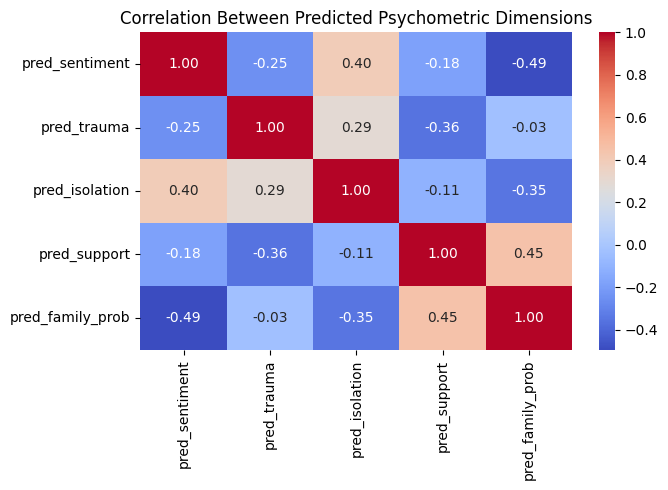


--- 🔍 Searching for best K via Silhouette Score ---
  K=2: silhouette=0.2275
  K=3: silhouette=0.2031
  K=4: silhouette=0.1869
  K=5: silhouette=0.1721
  K=6: silhouette=0.1632
  K=7: silhouette=0.1674
  K=8: silhouette=0.1630
  K=9: silhouette=0.1585
  K=10: silhouette=0.1545

🏆 Best K by silhouette: K=2 (score=0.2275)


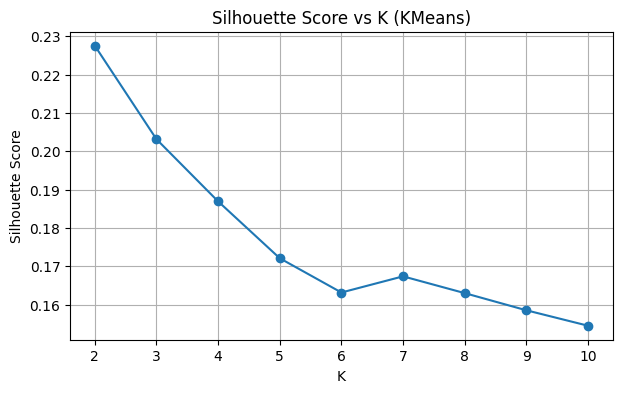


--- ⚙️ Fitting final KMeans with K=2 ---

--- 📈 Final KMeans Cluster Quality ---
Silhouette Score:        0.2275 (higher is better)
Calinski-Harabasz Score: 34382.59 (higher is better)
Davies-Bouldin Score:    1.5705 (lower is better)

--- 📊 Cluster Sizes ---
Cluster
0    49054
1    50946
Name: count, dtype: int64

--- 🧠 Cluster Profiles (mean scores) ---


,Sentiment,Trauma,Isolation,Support,FamilyHistoryProb,Size
Cluster,,,,,,
0,0.015657,0.561832,0.406539,0.738625,0.359856,49054
1,0.107193,0.641970,0.496124,0.621405,0.178478,50946


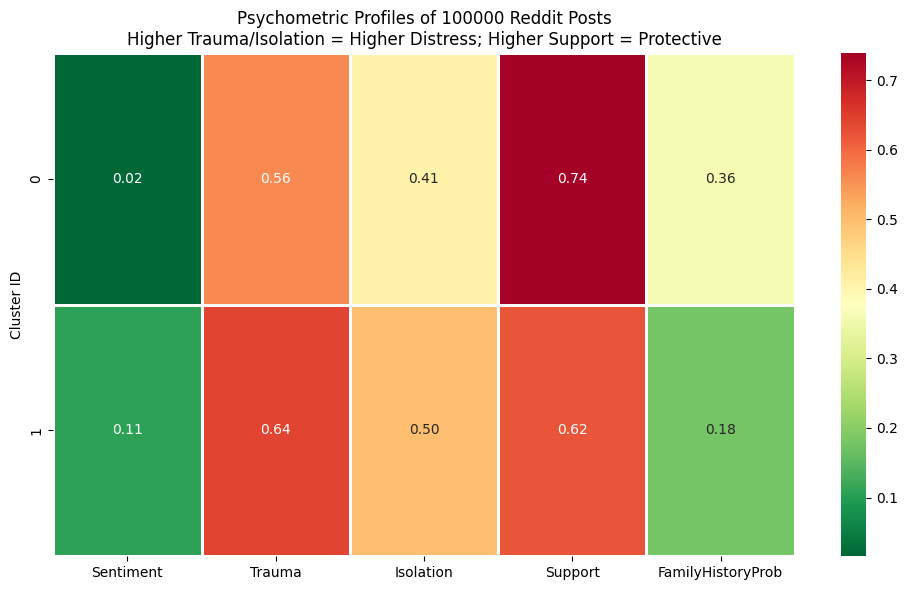


--- 🗺️ PCA 2D Visualization (sample up to 5k points) ---


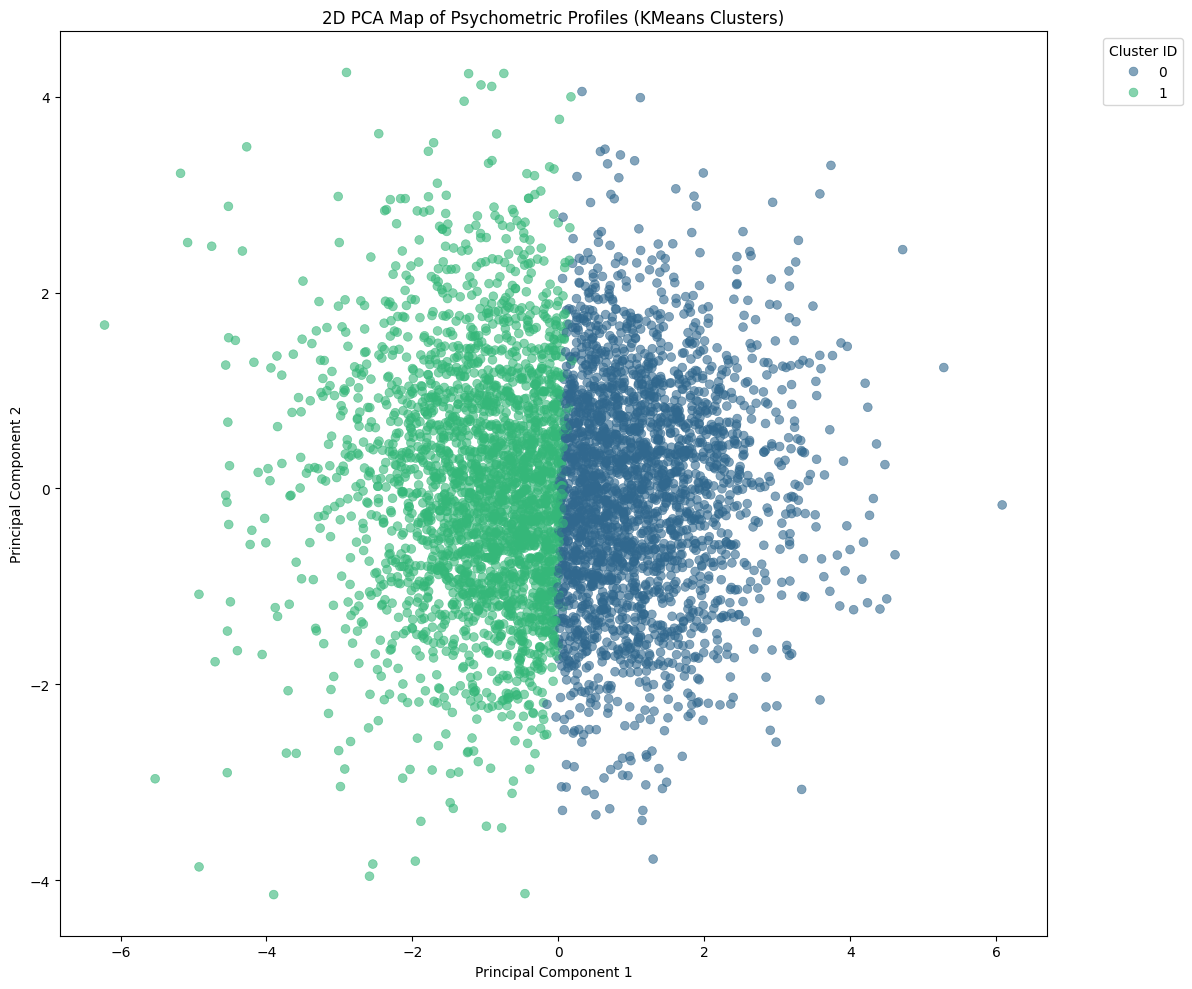


--- 🧭 UMAP Nonlinear Projection (sample up to 8k points) ---


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


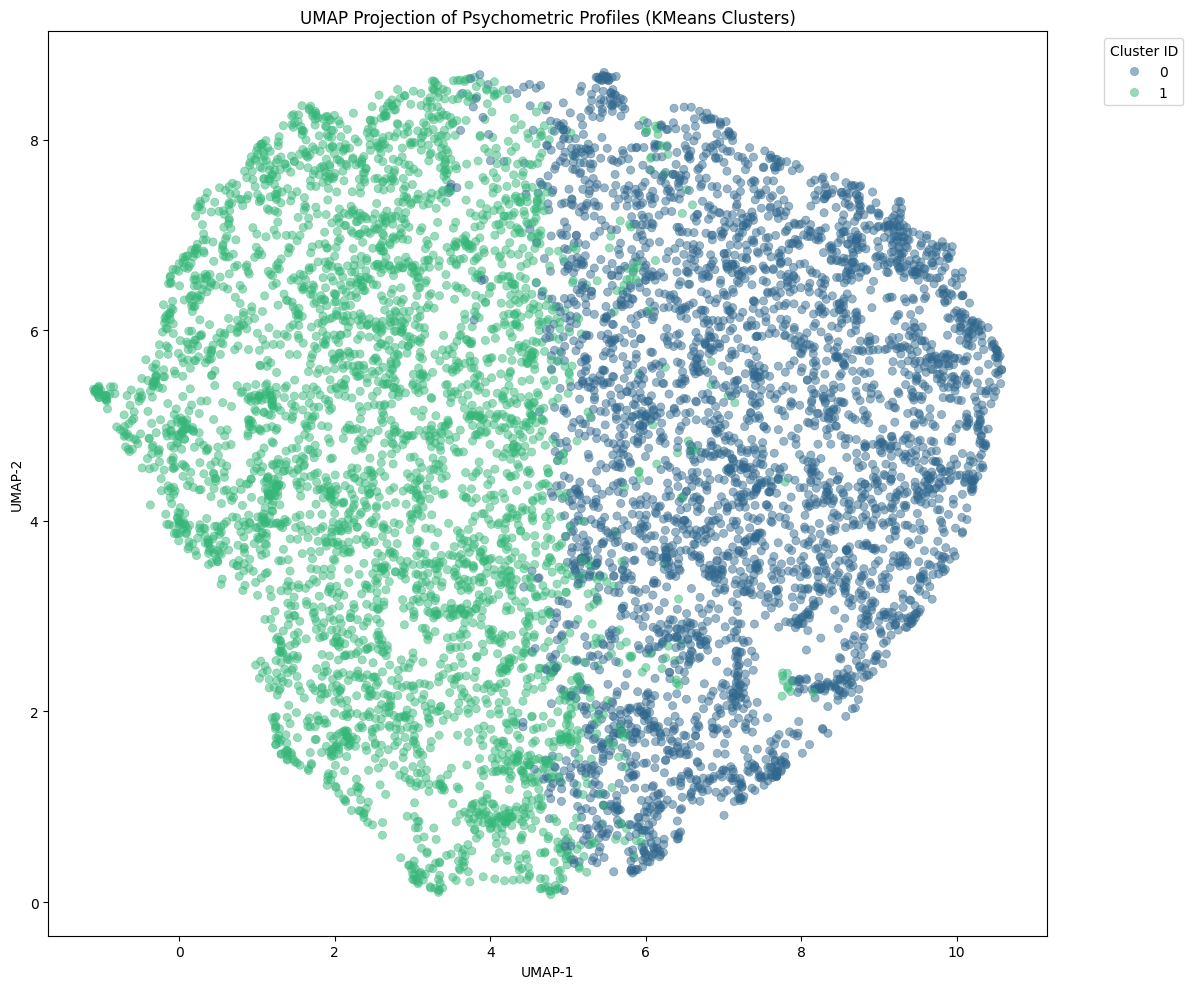


--- 🔁 Cluster Stability Analysis (Adjusted Rand Index) ---
Average ARI over subsamples (K=2): 0.0000

--- 🧬 Reddit Category vs Cluster ---


Cluster,0,1
label,,
addiction,294,941
adhd,3106,4466
alcoholism,171,813
anxiety,3503,6040
autism,938,479


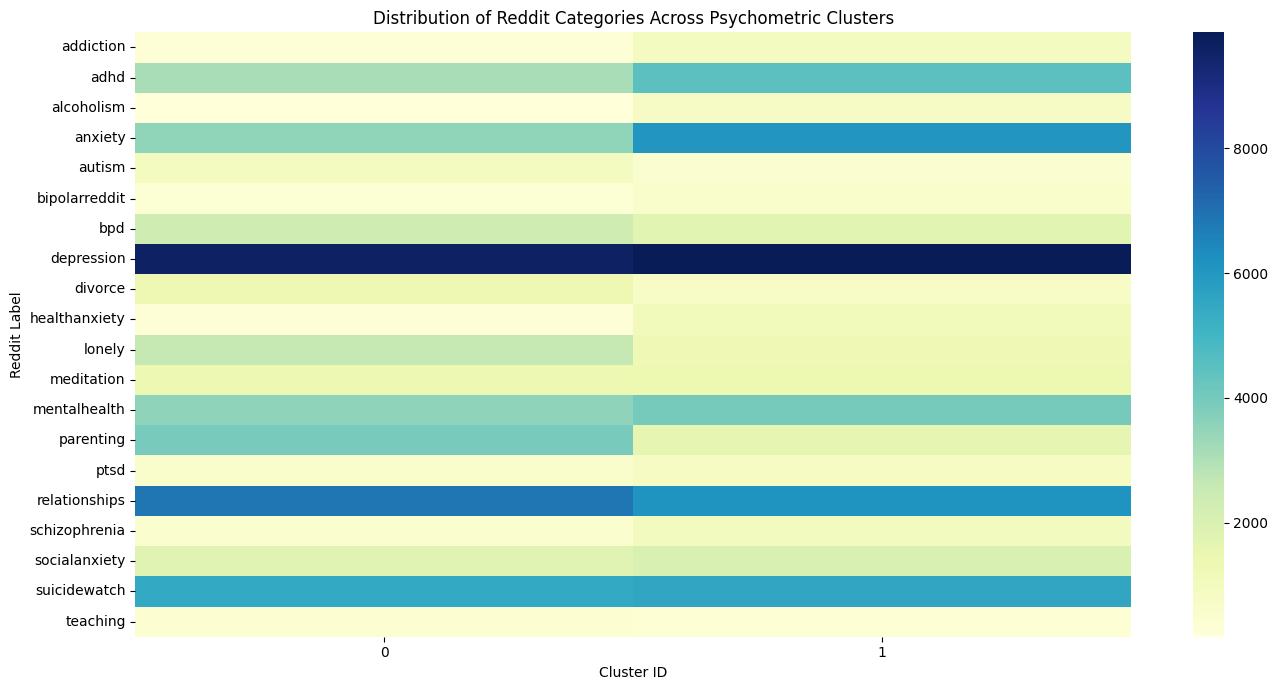


--- 📝 Real Examples from Each Cluster ---

🔹 CLUSTER 0 (Count: 49054):
  - "I always come here when I'm feeling alone For laying it all out, putting it out there, for reaching out and even for just straight up raging about something you must encounter in y..."
  - "Camping experience So I went camping with my boyfriend and his family and I’ve the worst anxiety in years. In certain moments I couldn’t function and I know it’s made it difficult ..."
  - "My 15 year old niece just called me crying. She told me that she’s pregnant and begged me to not tell anyone. Help!! I’m 27F and don’t have any kids yet, although my boyfriend and ..."

🔹 CLUSTER 1 (Count: 50946):
  - "I was daydreaming so intensely that I pulled out of a junction without looking I am so scared of losing concentration again when driving after this. I panicked and emergency stoppe..."
  - "life is so boring when I'm not high. I go to school. I come home. I do homework. I lay in bed and watch videos until bed. I lay down t

In [ ]:
# --- Cell 8: Robust Cluster Analysis & Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
)

print(f"--- 🧩 Starting Clustering on {len(final_df)} rows ---")

# 1. Copy & select features
df_cluster = final_df.copy()

# Use psychometric predictions as feature space
features = [
    "pred_sentiment",
    "pred_trauma",
    "pred_isolation",
    "pred_support",
    "pred_family_prob",
]

X = df_cluster[features].values

# 2. Standardize features (very important)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Correlation heatmap between dimensions (sanity check)
plt.figure(figsize=(7, 5))
corr = df_cluster[features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Predicted Psychometric Dimensions")
plt.tight_layout()
plt.show()

# 4. Choose K via silhouette score (2..10)
print("\n--- 🔍 Searching for best K via Silhouette Score ---")
k_sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_k)
    k_sil_scores.append((k, sil))
    print(f"  K={k}: silhouette={sil:.4f}")

best_k, best_sil = max(k_sil_scores, key=lambda x: x[1])
print(f"\n🏆 Best K by silhouette: K={best_k} (score={best_sil:.4f})")

# Optional: plot silhouette vs K
plt.figure(figsize=(7, 4))
plt.plot([k for k, s in k_sil_scores], [s for k, s in k_sil_scores], marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K (KMeans)")
plt.grid(True)
plt.show()

# 5. Fit final KMeans with best K and evaluate cluster quality
print(f"\n--- ⚙️ Fitting final KMeans with K={best_k} ---")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

sil_final = silhouette_score(X_scaled, df_cluster["Cluster"])
ch_final = calinski_harabasz_score(X_scaled, df_cluster["Cluster"])
db_final = davies_bouldin_score(X_scaled, df_cluster["Cluster"])

print("\n--- 📈 Final KMeans Cluster Quality ---")
print(f"Silhouette Score:        {sil_final:.4f} (higher is better)")
print(f"Calinski-Harabasz Score: {ch_final:.2f} (higher is better)")
print(f"Davies-Bouldin Score:    {db_final:.4f} (lower is better)")

# 6. Cluster profiles (mean psychometric scores per cluster)
cluster_profile = df_cluster.groupby("Cluster")[features].mean()
cluster_counts = df_cluster["Cluster"].value_counts().sort_index()

cluster_profile = cluster_profile.rename(
    columns={
        "pred_sentiment": "Sentiment",
        "pred_trauma": "Trauma",
        "pred_isolation": "Isolation",
        "pred_support": "Support",
        "pred_family_prob": "FamilyHistoryProb",
    }
)
cluster_profile["Size"] = cluster_counts

print("\n--- 📊 Cluster Sizes ---")
print(cluster_counts)

print("\n--- 🧠 Cluster Profiles (mean scores) ---")
display(cluster_profile)

# 7. Heatmap of cluster profiles
plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_profile.drop(columns=["Size"]),
    annot=True,
    cmap="RdYlGn_r",
    fmt=".2f",
    linewidths=1,
)
plt.title(
    f"Psychometric Profiles of {len(df_cluster)} Reddit Posts\n"
    "Higher Trauma/Isolation = Higher Distress; Higher Support = Protective"
)
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()

# 8. 2D PCA visualization (sampled)
print("\n--- 🗺️ PCA 2D Visualization (sample up to 5k points) ---")
sample_n = min(5000, len(df_cluster))
df_viz = df_cluster.sample(sample_n, random_state=42).copy()

pca = PCA(n_components=2, random_state=42)
X_viz_scaled = scaler.transform(df_viz[features].values)
coords = pca.fit_transform(X_viz_scaled)

df_viz["x_pca"] = coords[:, 0]
df_viz["y_pca"] = coords[:, 1]

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_viz,
    x="x_pca",
    y="y_pca",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    s=40,
    edgecolor=None,
)
plt.title("2D PCA Map of Psychometric Profiles (KMeans Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 9. UMAP projection for nonlinear structure (optional but powerful)
try:
    import umap

    print("\n--- 🧭 UMAP Nonlinear Projection (sample up to 8k points) ---")
    sample_umap_n = min(8000, len(df_cluster))
    df_umap = df_cluster.sample(sample_umap_n, random_state=123).copy()
    X_umap_scaled = scaler.transform(df_umap[features].values)

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    umap_coords = reducer.fit_transform(X_umap_scaled)

    df_umap["umap_x"] = umap_coords[:, 0]
    df_umap["umap_y"] = umap_coords[:, 1]

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=df_umap,
        x="umap_x",
        y="umap_y",
        hue="Cluster",
        palette="viridis",
        alpha=0.5,
        s=35,
        edgecolor=None,
    )
    plt.title("UMAP Projection of Psychometric Profiles (KMeans Clusters)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("⚠️ umap-learn not installed. Run `!pip install umap-learn` to enable UMAP plots.")

# 10. Cluster stability (Adjusted Rand Index across subsamples)
def cluster_stability(X_scaled, k, n_runs=5, sample_frac=0.5):
    labels_list = []
    n = X_scaled.shape[0]
    m = int(n * sample_frac)

    for r in range(n_runs):
        idx = np.random.choice(n, m, replace=False)
        km = KMeans(n_clusters=k, random_state=42 + r, n_init=10)
        labels_list.append(km.fit_predict(X_scaled[idx]))

    ari_scores = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            ari = adjusted_rand_score(labels_list[i], labels_list[j])
            ari_scores.append(ari)
    return np.mean(ari_scores) if ari_scores else float("nan")

print("\n--- 🔁 Cluster Stability Analysis (Adjusted Rand Index) ---")
ari = cluster_stability(X_scaled, k=best_k, n_runs=5, sample_frac=0.5)
print(f"Average ARI over subsamples (K={best_k}): {ari:.4f}")

# 11. Cross-tab: Reddit label distribution across clusters
if "label" in df_cluster.columns:
    print("\n--- 🧬 Reddit Category vs Cluster ---")
    ctab = pd.crosstab(df_cluster["label"], df_cluster["Cluster"])
    display(ctab.head())

    plt.figure(figsize=(14, 7))
    sns.heatmap(ctab, cmap="YlGnBu", cbar=True)
    plt.title("Distribution of Reddit Categories Across Psychometric Clusters")
    plt.xlabel("Cluster ID")
    plt.ylabel("Reddit Label")
    plt.tight_layout()
    plt.show()

# 12. Show real examples from each cluster
print("\n--- 📝 Real Examples from Each Cluster ---")
for i in range(best_k):
    count_i = cluster_counts.get(i, 0)
    print(f"\n🔹 CLUSTER {i} (Count: {count_i}):")
    examples = df_cluster[df_cluster["Cluster"] == i].sample(
        min(3, count_i), random_state=42
    )["processed_text"].values
    for ex in examples:
        snippet = str(ex).replace("\n", " ")[:180]
        print(f"  - \"{snippet}...\"")

In [ ]:
import torch
import os
from datetime import datetime

# Create a directory to save the model if it doesn't exist
output_dir = "./exported_model"
os.makedirs(output_dir, exist_ok=True)

# Generate a timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = os.path.join(output_dir, f"multitask_model_{timestamp}.pt")

# Check if multitask_model is defined before saving
if 'multitask_model' in locals() or 'multitask_model' in globals():
    # Save the model's state dictionary
    torch.save(multitask_model.state_dict(), output_path)
    print(f"Model exported successfully to: {output_path}")
else:
    print("Error: 'multitask_model' is not defined. Please ensure the model has been initialized and trained by running preceding cells (e.g., Cell 3 and Cell 4).")
    print("Skipping model export.")

NameError: name 'multitask_model' is not defined

In [ ]:
/content/exported_model

In [ ]:
import numpy as np
import torch

# ---- Bucketing helpers ----
def bucket_sentiment(x: float) -> str:
    # assumes roughly in [-1, 1]
    if x <= -0.7:
        return "very negative"
    elif x <= -0.3:
        return "negative"
    elif x <= -0.1:
        return "slightly negative"
    elif x < 0.1:
        return "neutral"
    elif x < 0.3:
        return "slightly positive"
    elif x < 0.7:
        return "positive"
    else:
        return "very positive"


def bucket_trauma(x: float) -> str:
    # assuming trauma ~ [0, 7]
    if x < 0.5:
        return "none / minimal"
    elif x < 2.0:
        return "low"
    elif x < 4.0:
        return "moderate"
    elif x < 6.0:
        return "high"
    else:
        return "very high"


def bucket_family(prob: float) -> str:
    # stricter thresholds so random noise isn't called "family distress"
    if prob < 0.2:
        return "unlikely"
    elif prob < 0.4:
        return "weak signal"
    elif prob < 0.7:
        return "likely"
    else:
        return "strongly indicated"


def cluster_label(cluster_id: int) -> str:
    # keep this coarse & non-critical
    if cluster_id == 0:
        return "family-oriented distress narrative (coarse)"
    else:
        return "individual-focused distress narrative (coarse)"


In [ ]:
import numpy as np
import torch
import os # Added for os.path.exists
from google.colab import drive # Added for drive.mount

# Ensure drive is mounted once if needed for model loading
# This function is designed to be called within infer_single_message if the model is not found.
# The user might need to manually mount drive if an interactive prompt appears.
def _ensure_drive_mounted():
    if not os.path.exists("/content/drive/MyDrive"):
        print("Google Drive not mounted. Attempting to mount...")
        try:
            drive.mount('/content/drive')
            print("Google Drive mounted.")
        except Exception as e:
            print(f"Warning: Failed to mount Google Drive: {e}. Model loading from Drive might fail.")
            # Do not re-raise, allow the function to continue and potentially fail later more gracefully.

def infer_single_message(text: str):
    global multitask_model # Declare multitask_model as global to potentially assign to it

    # Check if multitask_model is initialized and valid
    if 'multitask_model' not in globals() or not isinstance(multitask_model, torch.nn.Module):
        print("multitask_model not found or invalid in global scope. Attempting to load from Google Drive...")
        _ensure_drive_mounted() # Ensure Drive is mounted before attempting to load

        try:
            # Re-instantiate the model first. Requires 'model' (backbone) and 'MultiTaskModel' class
            # to be globally available (defined in Cell 1 and Cell 3 respectively).
            multitask_model = MultiTaskModel(model).to(device)

            # Define the path to the saved state_dict.
            # Assuming 'bloom-model' folder contains the state_dict of *this* MultiTaskModel.
            # User mentioned "bloom-model folder", so picking a common name like 'multitask_model_state_dict.pt'
            model_path_in_drive = "/content/drive/MyDrive/bloom-model/multitask_model_20251208_042224.pt"

            if os.path.exists(model_path_in_drive):
                multitask_model.load_state_dict(torch.load(model_path_in_drive, map_location=device))
                print(f"✅ multitask_model loaded successfully from {model_path_in_drive}")
                multitask_model.eval() # Set to eval mode after loading
            else:
                raise FileNotFoundError(f"Model file not found at {model_path_in_drive}. Please check the path and filename.")
        except Exception as e:
            print(f"❌ Error loading multitask_model from Drive: {e}")
            raise RuntimeError("Failed to initialize or load multitask_model.") from e

    # --- Original infer_single_message logic starts here ---
    inputs = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = multitask_model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
        )

    # raw predictions
    sent    = outputs["sentiment"].squeeze().item()
    trauma  = outputs["trauma"].squeeze().item()
    iso     = outputs["isolation"].squeeze().item()
    support = outputs["support"].squeeze().item()
    fam_log = outputs["family"].squeeze().item()
    fam_prob = float(torch.sigmoid(torch.tensor(fam_log)).item())

    # clip ranges
    trauma  = float(np.clip(trauma,  0.0, 7.0))
    iso     = float(np.clip(iso,     0.0, 4.0))
    support = float(np.clip(support, 0.0, 4.0))

    # 5-D vector for clustering
    vec = np.array([sent, trauma, iso, support, fam_prob]).reshape(1, -1)
    vec_scaled = scaler.transform(vec)
    cluster_id = int(kmeans.predict(vec_scaled)[0])
    cluster_name = cluster_label(cluster_id)

    # buckets (finer)
    sent_bucket   = bucket_sentiment(sent)
    trauma_bucket = bucket_trauma(trauma)
    family_bucket = bucket_family(fam_prob)

    return {
        "text": text,
        # raw values
        "sentiment_raw": sent,
        "trauma_raw": trauma,
        "family_prob_raw": fam_prob,
        "isolation_raw": iso,
        "support_raw": support,
        # buckets
        "sentiment_bucket": sent_bucket,
        "trauma_bucket": trauma_bucket,
        "family_bucket": family_bucket,
        # cluster
        "cluster_id": cluster_id,
        "cluster_label": cluster_name,
    }

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def analyze_conversation(raw_input: str):
    lines = [l.strip() for l in raw_input.split("\n") if l.strip()]
    if not lines:
        return "Please enter at least one message.", pd.DataFrame(), None

    records = [infer_single_message(text) for text in lines]
    df = pd.DataFrame(records)
    n = len(df)

    # --- Conversation-level aggregates ---
    first_sent = df["sentiment_raw"].iloc[0]
    last_sent  = df["sentiment_raw"].iloc[-1]
    delta_sent = last_sent - first_sent

    if n >= 2:
        if delta_sent >= 0.3:
            trend = "sentiment improving over time"
        elif delta_sent <= -0.3:
            trend = "sentiment worsening over time"
        else:
            trend = "sentiment relatively stable"
    else:
        trend = "only one message (no trend)"

    mean_trauma = df["trauma_raw"].mean()
    trauma_overall_bucket = bucket_trauma(mean_trauma)

    max_family_prob = df["family_prob_raw"].max()
    family_overall_bucket = bucket_family(max_family_prob)

    majority_cluster = int(df["cluster_id"].mode().iloc[0])
    majority_cluster_label = cluster_label(majority_cluster)

    summary_lines = [
        f"Messages analyzed: {n}",
        f"Overall sentiment trend: {trend}",
        f"Average trauma indicators: {mean_trauma:.2f} ({trauma_overall_bucket})",
        f"Family history context (conversation-level): {family_overall_bucket} "
        f"(max probability = {max_family_prob:.2f})",
        f"Dominant narrative type (cluster): Cluster {majority_cluster} – {majority_cluster_label}",
    ]
    overall_summary = "\n".join(summary_lines)

    # --- Sentiment trajectory plot ---
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(range(1, n + 1), df["sentiment_raw"], marker="o")
    ax.axhline(0.0, color="gray", linestyle="--", linewidth=1)
    ax.set_xlabel("Message index in conversation")
    ax.set_ylabel("Sentiment score (raw)")
    ax.set_title("Sentiment trajectory across messages")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    # --- Table: raw + buckets per message ---
    display_df = df[[
        "text",
        "sentiment_raw",
        "sentiment_bucket",
        "trauma_raw",
        "trauma_bucket",
        "family_prob_raw",
        "family_bucket",
        "cluster_label",
    ]].rename(columns={
        "text": "Message",
        "sentiment_raw": "Sentiment (raw)",
        "sentiment_bucket": "Sentiment (bucket)",
        "trauma_raw": "Trauma (raw)",
        "trauma_bucket": "Trauma (bucket)",
        "family_prob_raw": "Family Prob (raw)",
        "family_bucket": "Family (bucket)",
        "cluster_label": "Narrative Type",
    })

    return overall_summary, display_df, fig



In [ ]:
import gradio as gr
with gr.Blocks() as demo:
    gr.Markdown("# Psychometric Conversation Explorer")
    gr.Markdown(
        "Paste one or more messages (one per line).\n"
        "- The model will infer **sentiment, trauma, and family context** per message.\n"
        "- It will also show a **sentiment trajectory** across the conversation.\n"
        "- Raw values **and** fine-grained buckets are shown for debugging."
    )

    input_text = gr.Textbox(
        lines=8,
        label="Conversation (one message per line)",
        placeholder="I feel really low today...\nI'm trying to get better but it's hard...\n..."
    )

    analyze_btn = gr.Button("Analyze Conversation")

    summary_out = gr.Textbox(label="Conversation Summary", lines=6)
    table_out   = gr.Dataframe(label="Per-message Psychometric Tags", wrap=True)
    plot_out    = gr.Plot(label="Sentiment Trajectory")

    analyze_btn.click(
        fn=analyze_conversation,
        inputs=input_text,
        outputs=[summary_out, table_out, plot_out],
    )

demo.launch()



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ee187de184683cd93b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
